# Lab 1 - K-Nearest Neighbours and Cross Validation

This lab is about the implementation and analysis of the KNN algorithm for classification problems

In [1]:
# Packages used
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import Generator
import pickle


def _check_random_generator(rng: int | Generator | None) -> Generator:
    """Convert rng into a np.random.Generator instance."""
    if rng is None:
        print("⚠️  Warning: Set the `rng` parameter to a NumPy random generator\n"
              "   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure\n"
              "   your results are reproducible. Proceeding with a random seed for now.")
        return np.random.default_rng()
    if isinstance(rng, np.random.Generator):
        return rng
    if isinstance(rng, (int, np.integer)):
        return np.random.default_rng(rng)

### Data generation for binary classification

We start generating a training set for binary classification problems. Consider the following function, that generates random 2D points on the plane and assigns them a binary label according to their position w.r.t. a linear separator.

The function `linearBinaryClass`, given a sample size `n`, lower and upper bounds `low_D, high_D` for the domain of the samples and the linear function parameters `m, q`, generates a binary classification dataset, i.e., it returns `X` and `Y`.

The signature of the function is the following:

`X, Y = linearBinaryClass(n, low_D, high_D, m, q)`

where
- **n** is the number of samples to be generated
- **low_D** and **high_D** are, respectively, the lower and upper bounds for the domain of the samples i.e.
    $$
    X_{i,j} \sim \mathcal{U}(\text{low\_D}, \text{high\_D})
    $$
- **m, q** are the linear function parameters
- **X**, **Y**: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)


In [2]:
def linearBinaryClass(n, low_D, high_D, m, q, rng: int | Generator | None = None):
    rng = _check_random_generator(rng)
    X = (rng.random((n, 2)) * (high_D - low_D)) + low_D
    Y = np.sign((X[:,1] - (m * X[:,0]) + q))
    Y[Y==0] = 1
    return X,Y

### Computing the distance between input points

In order to build the KNN estimator we need to resort to a distance function.

Consider a function that computes the euclidean distance between two points...

In [3]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

... and then a function that computes all the distance between two set of points stored in two matrices.

In [ ]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    #  : Implement the computation of the pairwise Euclidean distances
    # Expected output:
    # D is a (n1 × n2) array, where D[i, j] equals the Euclidean distance
    # between the i-th sample in X1 and the j-th sample in X2.

    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            D[i, j] = euclidDistance(X1[i], X2[j])

    return D

The usage is the following:

**D = allDistances(X1,X2)**

where
- **X1** is a matrix of size $n_1 \times D$, where each row is a D-dimensional point
- **X2** is a matrix of size $n_2 \times D$, where each row is a D-dimensional point
- **D** is a matrix of size $n_1 \times n_2$, where each element `D[i,j]` is the distance between points (`X1[i, :]`, `X2[j, :]`)

### Adding noise to the samples

To make the task harder, we may want to perturb the labels with some noise.

In our case, we have binary labels and a common way of adding noise is to flip the value of a small percentage of the labels. For example, if a label was $+1$ it will become $-1$.

The `flipLabels` function takes two arguments:
 - `Y`, the numpy array of original labels
 - `P`, an integer between 1 and 100 specifying the percentage of labels which will be flipped
and returns an array of the same shape as `Y`, which contains the noisy labels.


In [5]:
def flipLabels(Y, P: int, rng: int | Generator | None = None):
    assert 0 <= P <= 100, 'P should be between 0 and 100'
    if P == 0:
        return Y
    rng = _check_random_generator(rng)
    ny = len(Y)
    indices_to_flip = rng.choice(range(ny), int(ny * (P / 100)), replace=False)
    Y_noisy = Y.copy()
    Y_noisy[indices_to_flip] *= -1
    return Y_noisy

### Visualize the dataset

A utiliy function to visualize the dataset for binary classification

In [6]:
def plotData(Xd, Yd):
    x = Xd[:, 0]
    y = Xd[:, 1]
    plt.scatter(x[Yd==1], y[Yd==1], c="#C59434", marker='o', s=50, zorder=10, alpha=0.8)
    plt.scatter(x[Yd==-1], y[Yd==-1], c="#092C48", marker='o', s=50, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    plt.show()

### The KNN classifier

We are now ready to use the KNN algorithm to estimate the classification function. 

Implement the `kNNClassify` function which train a KNN classifier on given training set and returns predictions on a given test set. 

The signature of the function is the following:

`Ypred = kNNClassify(Xtr, Ytr, k, Xte)`

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered
- **Xte** is a matrix of size [nte, D], where each row is a D-dimensional point (INPUT IN THE **TEST SET**)
- **Ypred** is an array of size [nte], where each element is a binary label (ESTIMATED OUTPUT FOR THE **TEST SET**)

where [ntr] and [nte] are respectively the number of points in the training set and the number of points in the test set

In [7]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0] # number of the training inputs
    n_test = Xte.shape[0]  # number of the test inputs

    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # Compute all the distances from TEST input and TRAINING input
    dist = allDistances(Xte, Xtr)
    
    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):
        # Hint 1: take all the distances for the current test point
        # Hint 2: Sort the indices of the distances
        # Hint 3: Get the indices of the k lowest of distances
        # Hint 4: Compute the mean of the output values of the corresponding training points and taking the sign of it.
        
        Ypred[idx] = np.sign(np.mean(Ytr[np.argsort(dist[idx])[:k]]))
    return Ypred


### Visualizing the separating function

The visualization of the separating function on the training set, i.e. the function estimated by classification algorithm for discriminating between classes, is of benefit for appreciating the behavior of the binary classifier. To visualize the separating function use the following:

**_separatingFkNN(Xtr, Ytr, k, Xte, Yte)_**

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered
- **Xte** is a matrix of size [nte, D], where each row is a D-dimensional point (INPUT IN THE **TEST SET**)
- **Yte** is an array of size [nte], where each element is a binary label (OUTPUT IN THE **TEST SET**)


In [8]:
def separatingFkNN(Xtr, Ytr, k, Xte, Yte):
    x1min, x1max = min(Xtr[:, 0]), max(Xtr[:, 0])
    x2min, x2max = min(Xtr[:, 1]), max(Xtr[:, 1])

    # Number of mesh points for visualization
    Nx1, Nx2 = 100, 100
    x1mesh = np.linspace(x1min, x1max, Nx1)
    x2mesh = np.linspace(x2min, x2max, Nx2)

    # Create mesh and reshape x1 and x2 into a single array of points
    x1, x2 = np.meshgrid(x1mesh, x2mesh)
    meshpoints = np.column_stack((x1.ravel(), x2.ravel()))

    # Run kNN classifier on mesh points
    ypred = kNNClassify(Xtr, Ytr, k, meshpoints)

    plt.subplots()
    plt.contour(x1mesh, x2mesh, np.reshape(ypred, (Nx2, Nx1)), levels=[0])

    # Optionally plot training data
    # plt.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)

    # Plot test points
    plt.scatter(Xte[Yte==1, 0], Xte[Yte==1, 1], c="#C59434", marker='o', s=50, zorder=10, alpha=0.8)
    plt.scatter(Xte[Yte==-1, 0], Xte[Yte==-1, 1], c="#092C48", marker='o', s=50, zorder=10, alpha=0.8)

    plt.xlim(x1min, x1max)
    plt.ylim(x2min, x2max)
    plt.title(f"Separating function, k={k}")
    plt.show()

### Evaluating the goodness of a classifier

To evaluate how good is the classification function estimated by the KNN, we compare the predicted binary labels and expected (true) ones, with the following function:

`err = calcError(Ypred, Ytrue)`

where
- **Ypred** is an array of size $n$, where each element is a binary label predicted by the classifier
- **Ytrue** is an array of size $n$, where each element is the true binary label
- **err** is the fraction of wrongly classified elements wrt the total number


In [9]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

### Analysis: Noise-free case

In this assignment, we start to play with the NN classifier. In specific:

- 1.Generate a training set WITHOUT NOISE
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Compute the error on the TRAINING and then on the TEST SET



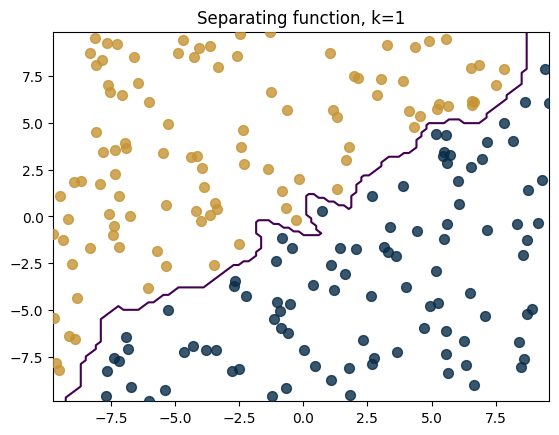

With K=1 the error on the test set is 0.040
With K=1 the error on the training set is 0.000


In [ ]:
### Generate training and test sets, build and evaluate the KNN classifier
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 1

# : Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q, rng=42)

# : Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr, Ytr)

# : Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q, rng=24)

# : Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

# : Compute the error on the TEST SET
err =  calcError(Ypred, Yte)

print(f"With K={k} the error on the test set is {err:.3f}")

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr, Ytr)
print(f"With K={k} the error on the training set is {errtr:.3f}")

### Analysis: adding noise

Keeping the parameters of the function and the number of points as in the previous assignment:

- 1.Generate a training set WITH NOISE (for instance with 10% of flipped labels)
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Evaluate the NN classifier on the TRAINING and on the TEST SET
- 5.Compute the obtained error on the TRAINING and on the TEST SET

- Repeat the steps from 1 to 5 with the **KNN** algorithm, setting for instance K=5

OBSERVE WHAT CHANGES...

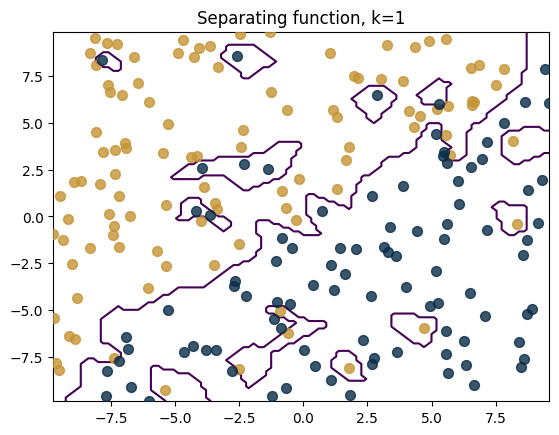

With K=1 the error on the test set is 0.200
With K=1 the error on the training set is 0.000


In [ ]:
# ... your code goes here... #
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

noise_percentage = 10 # percentage of labels to flip

k = 1

# : Generate a training set WITH NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q, rng=42)
Ytr = flipLabels(Ytr, noise_percentage, rng=1)

# : Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr, Ytr)

# : Generate a test set WITH NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q, rng=24)
Yte = flipLabels(Yte, noise_percentage, rng=24)

# : Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

# : Compute the error on the TEST SET
err =  calcError(Ypred, Yte)

print(f"With K={k} the error on the test set is {err:.3f}")

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr, Ytr)
print(f"With K={k} the error on the training set is {errtr:.3f}")

Describe here what changes: 

the poit are separeted in two grups separated by a line, but in ech grup there are some points of the other class due to the noise added.

the error on the training set is higher than in the previous case without noise

### Analysis: comparison of different scenarios

Analyse the performance of the **KNN** with plots, considering in particular the following:



- **SCENARIO 1**: Fix the number n of points to 200, fix the amount of noise to 10%, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the value of K

- **SCENARIO 2**: Fix the number n of points to 200, fix the value of K to a reasonable number of neighbours, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the amount of noise

- **SCENARIO 3**: Fix noise and K to two reasonable values, fix the number of TEST samples to 300, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the number of TRAINING samples (e.g. from 30 to 300 with steps 30)

For each scenario, describe what happen

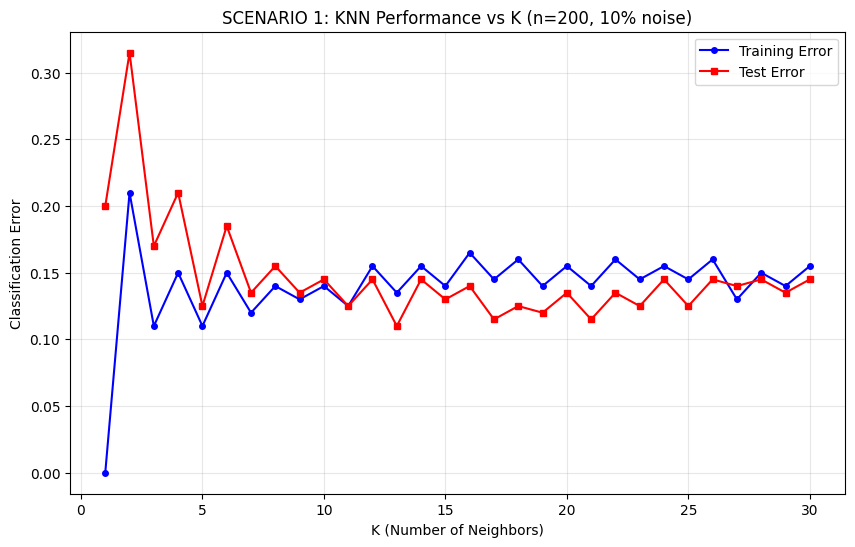


Best K based on test error: 13
Best test error: 0.110


In [40]:
# ... your code for SCENARIO 1 goes here... 
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

noise_percentage = 10 # percentage of labels to flip

# Generate training set WITH NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q, rng=42)
Ytr = flipLabels(Ytr, noise_percentage, rng=1)

# Generate test set WITH NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q, rng=24)
Yte = flipLabels(Yte, noise_percentage, rng=24)

# Range of K values to test
k_values = range(1, 31)  # Test K from 1 to 30

# Lists to store errors
train_errors = []
test_errors = []

# Evaluate KNN classifier for different K values
for k in k_values:
    # Predict on training set
    Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
    errtr = calcError(Ypredtr, Ytr)
    train_errors.append(errtr)
    
    # Predict on test set
    Ypred = kNNClassify(Xtr, Ytr, k, Xte)
    err = calcError(Ypred, Yte)
    test_errors.append(err)
    

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_errors, 'b-o', label='Training Error', markersize=4)
plt.plot(k_values, test_errors, 'r-s', label='Test Error', markersize=4)
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Classification Error')
plt.title('SCENARIO 1: KNN Performance vs K (n=200, 10% noise)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find best K based on test error
best_k = k_values[np.argmin(test_errors)]
print(f"\nBest K based on test error: {best_k}")
print(f"Best test error: {min(test_errors):.3f}")

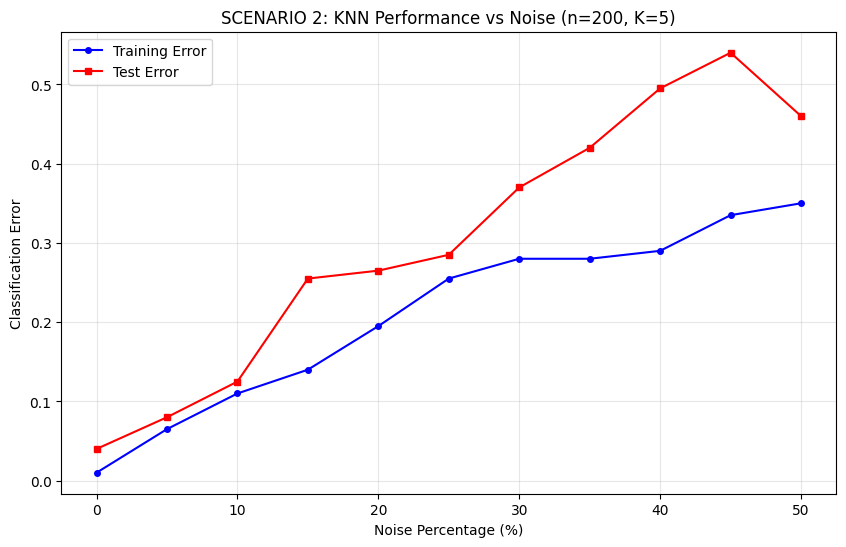


Using K=5:
No noise: Training error = 0.010, Test error = 0.040
50% noise: Training error = 0.350, Test error = 0.460


In [42]:
# ... your code for SCENARIO 2 goes here...
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 5  # Fix K to a reasonable value

# Range of noise percentages to test
noise_percentages = range(0, 51, 5)  # Test noise from 0% to 50% in steps of 5%

# Lists to store errors
train_errors = []
test_errors = []

# Evaluate KNN classifier for different noise levels
for noise_percentage in noise_percentages:
    # Generate training set WITH NOISE
    Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q, rng=42)
    if noise_percentage > 0:
        Ytr = flipLabels(Ytr, noise_percentage, rng=1)
    
    # Generate test set WITH SAME NOISE LEVEL
    Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q, rng=24)
    if noise_percentage > 0:
        Yte = flipLabels(Yte, noise_percentage, rng=24)
    
    # Predict on training set
    Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
    errtr = calcError(Ypredtr, Ytr)
    train_errors.append(errtr)
    
    # Predict on test set
    Ypred = kNNClassify(Xtr, Ytr, k, Xte)
    err = calcError(Ypred, Yte)
    test_errors.append(err)
    
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(noise_percentages, train_errors, 'b-o', label='Training Error', markersize=4)
plt.plot(noise_percentages, test_errors, 'r-s', label='Test Error', markersize=4)
plt.xlabel('Noise Percentage (%)')
plt.ylabel('Classification Error')
plt.title(f'SCENARIO 2: KNN Performance vs Noise (n=200, K={k})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find the noise level where errors start to significantly increase
print(f"\nUsing K={k}:")
print(f"No noise: Training error = {train_errors[0]:.3f}, Test error = {test_errors[0]:.3f}")
print(f"50% noise: Training error = {train_errors[-1]:.3f}, Test error = {test_errors[-1]:.3f}")

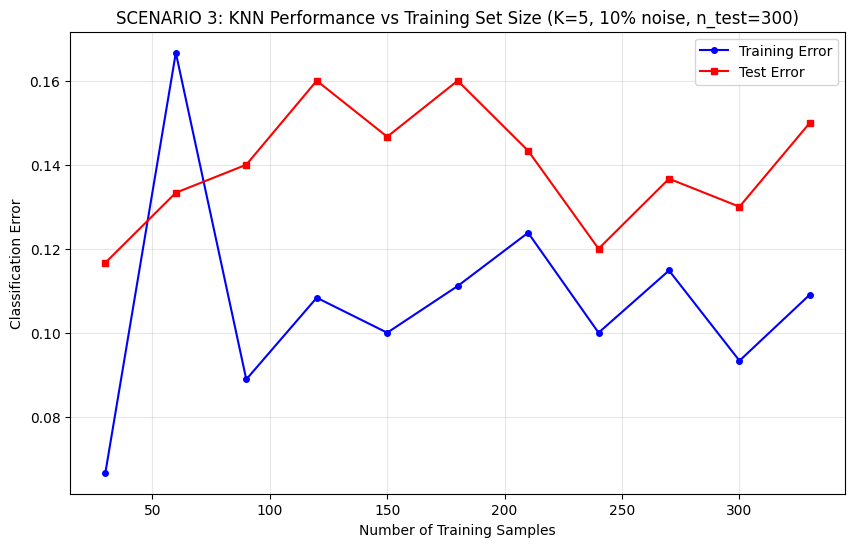


Best training set size based on test error: 30
Best test error: 0.117
Training error at best size: 0.067

Improvement from n_train=30 to n_train=300:
Training error: 0.067 -> 0.109
Test error: 0.117 -> 0.150


In [41]:
# ... your code for SCENARIO 3 goes here...
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

noise_percentage = 10  # Fix noise to a reasonable value
k = 5  # Fix K to a reasonable value
n_test = 300  # Fix number of test samples

# Range of training sample sizes to test
n_train_values = range(30, 331, 30)  # From 30 to 300 with steps of 30

# Lists to store errors
train_errors = []
test_errors = []

# Generate a fixed test set (same for all experiments)
Xte, Yte = linearBinaryClass(n_test, low_D, high_D, m, q, rng=24)
Yte = flipLabels(Yte, noise_percentage, rng=24)

# Evaluate KNN classifier for different training set sizes
for n_train in n_train_values:
    # Generate training set WITH NOISE
    Xtr, Ytr = linearBinaryClass(n_train, low_D, high_D, m, q, rng=42)
    Ytr = flipLabels(Ytr, noise_percentage, rng=1)
    
    # Predict on training set
    Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
    errtr = calcError(Ypredtr, Ytr)
    train_errors.append(errtr)
    
    # Predict on test set
    Ypred = kNNClassify(Xtr, Ytr, k, Xte)
    err = calcError(Ypred, Yte)
    test_errors.append(err)
    

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_train_values, train_errors, 'b-o', label='Training Error', markersize=4)
plt.plot(n_train_values, test_errors, 'r-s', label='Test Error', markersize=4)
plt.xlabel('Number of Training Samples')
plt.ylabel('Classification Error')
plt.title(f'SCENARIO 3: KNN Performance vs Training Set Size (K={k}, {noise_percentage}% noise, n_test={n_test})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find the training set size with best test error
best_n_train = n_train_values[np.argmin(test_errors)]
print(f"\nBest training set size based on test error: {best_n_train}")
print(f"Best test error: {min(test_errors):.3f}")
print(f"Training error at best size: {train_errors[np.argmin(test_errors)]:.3f}")

# Show improvement from smallest to largest training set
print(f"\nImprovement from n_train=30 to n_train=300:")
print(f"Training error: {train_errors[0]:.3f} -> {train_errors[-1]:.3f}")
print(f"Test error: {test_errors[0]:.3f} -> {test_errors[-1]:.3f}")

Insert here your observations:
- **SCENARIO 1**:the error whit the increase of k govergers to a bit over the ammount of noise added, this is because with a high k the classifier is less sensible to noise
- **SCENARIO 2**:when the noise increase the error increase too
- **SCENARIO 3**:knn dose not improve with a higher number of training samples


### Selecting the hyperparameter with Cross-Validation

In this part we apply cross-validation to select the best value of the hyperparameter K. To this purpose, we suggest you use the following datasets we already collected for you (see folder Material):

  - (Training1, Test1): n=70, no noise, suggested K values are in the range 1 ... 13
  - (Training2, Test2): n=40, no noise, suggested K values are in the range 1 ... 23
  - (Training3, Test3): n=200, 20% flipped labels, suggested K values are in the range 1 ... 31
  - (Training4, Test4): n=200, 5% flipped labels, suggested K values are in the range 1 ... 19

Note that each dataset includes both a training and a test set. You **cannot use the test set to choose k**: you should assume you don't have access to the test set when doing model selection!

To load a dataset use function
`Xtr, Ytr, Xte, Yte = load_dataset(path_tr, path_te)`

Where:
- **_path\_tr_**: is the path to the file which contains the training set
- **_path\_te_**: is the path to the file which contains the test set

and it returns:
- **_Xtr_**: Inputs of training set
- **_Ytr_**: Outputs of training set
- **_Xte_**: Inputs of test set
- **_Yte_**: Outputs of test set

In [15]:
### If you use colab uncomment these line and upload Material.zip

#from google.colab import files

#files.upload()
#!unzip Material.zip

In [16]:
# This is the utility function to load the dataset
def load_dataset(path_tr, path_te):
    with open(path_tr,"rb") as f:
        [Xtr, Ytr] = pickle.load(f)
    with open(path_te,"rb") as f:
        [Xte, Yte] = pickle.load(f)
    return Xtr, Ytr, Xte, Yte

### K-Fold cross validation

In K-Fold cross validation, the data are split into K parts of approximately equal size, and K different models are trained each time leaving out one of the parts of data. Then the estimate for the test error is the mean of the error of the K different models.

In [ ]:
def KFoldCVkNN(Xtr, Ytr, num_folds, k_list, rng: int | Generator | None = None):
    """Run K-Fold CV for the kNN model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - k_list : List[int]
         the values of k (for k-NN) to try
     - rng : Optional[int | Generator | None]
         optional random state

    Returns:
    --------
     - best_k : int
         The value of k (in k_list) which obtains the best average validation error
     - best_k_idx : int
         The index of the best_k element in k_list
     - tr_err_mean : np.array
         A 1D array of the same length as k_list, with the average training error for each tested k.
     - tr_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation 
         of the training error for each tested k.
     - val_err_mean : np.array
         A 1D array of the same length as k_list, with the average validation error for each tested k.
     - val_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation
         of the validation error for each tested k.
    """
    rng = _check_random_generator(rng)
    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = len(k_list)

    n_tot = Xtr.shape[0]

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, num_folds))
    val_errors = np.zeros((num_k, num_folds))

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rng.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        # Split training set in training part and validation part
        # Hint: you can use boolean mask as index vector to split Xtr and Ytr
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]
        x_val = Xtr[val_mask==True]
        y_val = Ytr[val_mask==True]
        
        for k_idx, current_k in enumerate(k_list):
            #  : Compute the training error of the kNN classifier for the given value of k
            tr_errors[k_idx, fold_idx] = calcError(kNNClassify(x_train, y_train, current_k, x_train), y_train)
            #  : Compute the validation error of the kNN classifier for the given value of k
            val_errors[k_idx, fold_idx] = calcError(kNNClassify(x_train, y_train, current_k, x_val), y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)
    # 2) mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    # 3) best k (k which minimize mean validation error) and index of best k in k_list
    best_k = k_list[np.argmin(val_err_mean)]
    best_k_idx = np.where(k_list == best_k)
    
    return best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std

In [37]:
# Now we call the K-Fold Cross Validation on one of the dataset, for instance the first one
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training1.dat", "./Material/Classification/Test1.dat")

num_folds = 5
k_list = range(1, 13, 2)
best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(
    Xtr, Ytr, num_folds, k_list)

print(f"The best k chosen with {num_folds} folds is {best_k} with error "
      f"{np.min(val_err_mean) * 100:.2f} +- {val_err_std[np.argmin(val_err_mean)] * 100:.2f}%")

⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.
The best k chosen with 5 folds is 1 with error 1.43 +- 2.86%


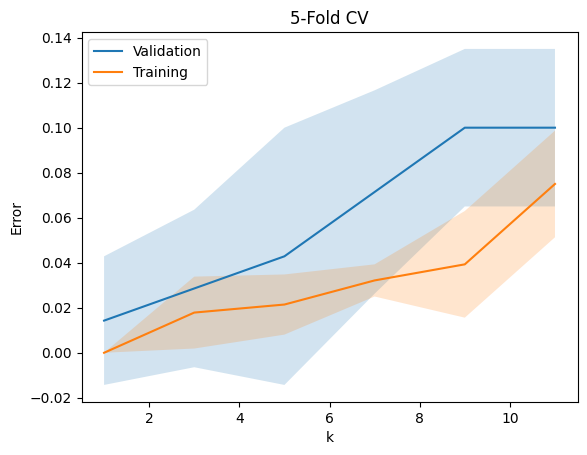

In [38]:
# We plot the training e validation error
fig, ax = plt.subplots()
ax.plot(k_list, val_err_mean, label="Validation")
ax.fill_between(k_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
ax.plot(k_list, tr_err_mean, label="Training")
ax.fill_between(k_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

ax.set_title(f"{num_folds}-Fold CV")
ax.set_ylabel("Error")
ax.set_xlabel("k")
ax.legend()

Compare the curves of the training and validation error: what can you observe?

In [20]:
# Finally, evaluate the model with the best k on the test set now
Ypred = kNNClassify(Xtr, Ytr, best_k, Xte)
te_err = calcError(Ypred, Yte)

print(f"The test error with the best k ({best_k}) is: {te_err*100:.3f}%")

The test error with the best k (1) is: 7.143%


### Cross validation and Noise in k-NN

In this final task we consider the effect of noise on the best k (chosen with k-fold CV).

We will use dataset3 which has high noise (20%), and dataset4 which has low noise (5%).

You will have to do the following:
 1. Use k-fold CV to find the best k for datasets 3 and 4.
 2. Compare the obtained values of k, with the actual best k on the test error of the two datasets. This should be a sanity check: if the errors on k-fold CV and on the test set are very different, something may be wrong with your code.
 3. Comment on how noise affects the best k: does a more noisy dataset need a higher or a lower k, and why? It may be useful to plot the separating function (using the `separatingFkNN` function) of k-NN with the best k for the two datasets.

Best k for Dataset 3: 17
CV validation error: 21.00 ± 6.04%
Best k for Dataset 4: 5
CV validation error: 6.50 ± 2.55%


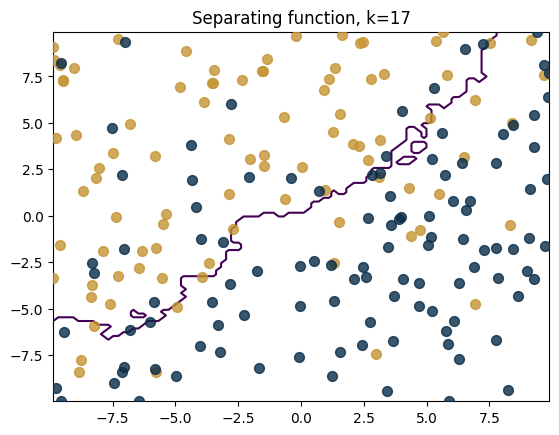

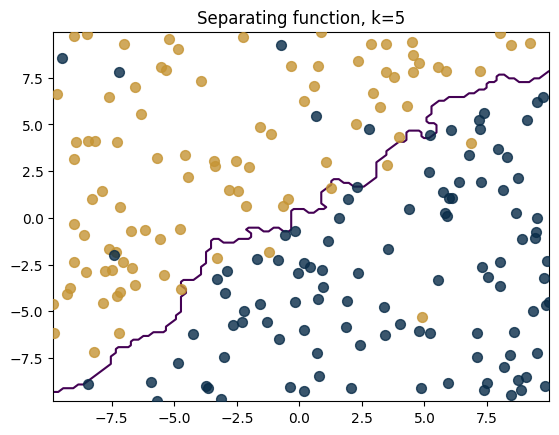

In [ ]:
# ... your code goes here... #
Xtr3, Ytr3, Xte3, Yte3 = load_dataset("./Material/Classification/Training3.dat", "./Material/Classification/Test3.dat")
Xtr4, Ytr4, Xte4, Yte4 = load_dataset("./Material/Classification/Training4.dat", "./Material/Classification/Test4.dat")

num_folds = 5
k_list3 = range(1, 32, 2)  # Suggested range for dataset 3: 1...31
k_list4 = range(1, 20, 2)  # Suggested range for dataset 4: 1...19

#Use k-fold CV to find the best k for dataset 3 (high noise)
best_k3, best_k_idx3, tr_err_mean3, tr_err_std3, val_err_mean3, val_err_std3 = KFoldCVkNN(
    Xtr3, Ytr3, num_folds, k_list3, rng=42)

print(f"Best k for Dataset 3: {best_k3}")
print(f"CV validation error: {val_err_mean3[np.argmin(val_err_mean3)] * 100:.2f} ± {val_err_std3[np.argmin(val_err_mean3)] * 100:.2f}%")

# Use k-fold CV to find the best k for dataset 4 (non-linear)
best_k4, best_k_idx4, tr_err_mean4, tr_err_std4, val_err_mean4, val_err_std4 = KFoldCVkNN(
    Xtr4, Ytr4, num_folds, k_list4, rng=42)

print(f"Best k for Dataset 4: {best_k4}")
print(f"CV validation error: {val_err_mean4[np.argmin(val_err_mean4)] * 100:.2f} ± {val_err_std4[np.argmin(val_err_mean4)] * 100:.2f}%")

separatingFkNN(Xtr3, Ytr3, best_k3, Xtr3, Ytr3)
separatingFkNN(Xtr4, Ytr4, best_k4, Xtr4, Ytr4)

a more noisy dataset needs a higher k, because with a higher k the classifier is less sensible to noise